# HR-analytics

In [1]:
! pip install shap -q
! pip install phik -q
! pip install imbalanced-learn -q
! pip install -U scikit-learn -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import phik
from scipy import stats as st

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 

from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    make_scorer
)
from sklearn.model_selection import GridSearchCV

import shap

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.exceptions import FitFailedWarning
from warnings import simplefilter
import os

simplefilter(action='ignore', category=FutureWarning)

/Users/arina/GitProjects/machine_learning_projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RANDOM_STATE = 42

## Features
- id — unique employee identifier;
- dept — department where the employee works;
- level — job position level;
- workload — employee's workload level;
- employment_years — duration of employment at the company (in years);
- last_year_promo — indicates whether the employee was promoted in the last year;
- last_year_violations — indicates whether the employee violated the employment contract in the last year;
- supervisor_evaluation — performance score given by the supervisor;
- salary — employee’s monthly salary;
- job_satisfaction_rate — level of employee satisfaction with their job at the company, target feature.

### Data Loading

In [4]:
rate_df = pd.read_csv('../datasets/train_job_satisfaction_rate.csv')
test_rate_df = pd.read_csv('../datasets/test_target_job_satisfaction_rate.csv')
features_df = pd.read_csv('../datasets/test_features.csv')

In [5]:
def df_description(df):
    print('shape: ', df.shape)
    display(df.head())
    df.info()
    display(pd.DataFrame(round(df.isna().mean()*100,2)).style.background_gradient('coolwarm'))

In [6]:
df_description(rate_df)

shape:  (4000, 10)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,0
id,0.000000
dept,0.150000
level,0.100000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000
job_satisfaction_rate,0.000000


In [7]:
df_description(test_rate_df)

shape:  (2000, 2)


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,0
id,0.000000
job_satisfaction_rate,0.000000


In [8]:
df_description(features_df)

shape:  (2000, 9)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,0
id,0.000000
dept,0.100000
level,0.050000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000


In [9]:
def get_num_cat_attributes(df):
    return df.select_dtypes(include=['object']).columns.to_list(), df.select_dtypes(exclude=['object']).columns.to_list()

In [10]:
rate_cat, rate_num = get_num_cat_attributes(rate_df)
rate_num.remove('id')
print(rate_cat, rate_num)

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'] ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [11]:
test_rate_cat, test_rate_num = get_num_cat_attributes(test_rate_df)
test_rate_num.remove('id')
print(test_rate_cat, test_rate_num)

[] ['job_satisfaction_rate']


In [12]:
features_cat, features_num = get_num_cat_attributes(features_df)
features_num.remove('id')
print(features_cat, features_num)

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations'] ['employment_years', 'supervisor_evaluation', 'salary']


Before checking for duplicates, we will verify the spelling of categories.








In [13]:
for attr in rate_cat:
    print(f'{attr}: {rate_df[attr].unique()}')

dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'high' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


In [14]:
for attr in features_cat:
    print(f'{attr}: {features_df[attr].unique()}')

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'low' 'high' ' ']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


There are no typos in the category names. However, some attributes contain unfilled (missing) fields.

In [15]:
features_df.query('dept == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [16]:
features_df.query('workload == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [17]:
features_df = features_df.apply(lambda x: x.replace({'sinior':'senior'}, regex=True))

In [18]:
rate_df.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [19]:
rate_df.duplicated(['dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate']).sum()

np.int64(245)

In [20]:
rate_df.duplicated().sum()

np.int64(0)

In [21]:
rate_df.drop_duplicates(['dept', 'level', 'workload', 'employment_years',
                          'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
                          'salary', 'job_satisfaction_rate'], inplace=True)

In [22]:
rate_df.shape

(3755, 10)

In [23]:
features_df.duplicated(['dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary']).sum()

np.int64(557)

In [24]:
test_rate_df.duplicated('id').sum()

np.int64(0)

### Exploratory Data Analysis

We look at the data in the context of the target attribute. Here, the data is divided into groups with satisfaction levels above and below 0.5.

In [25]:
rate_df = rate_df.set_index('id')

In [26]:
def cat_plots(df, columns, group=None):
    if group is None:
        for col in columns:
            counts = df[col].value_counts()
            labels = counts.index.tolist()
            sizes = counts.values.tolist()

            plt.figure(figsize=(3, 3))
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
            plt.axis('equal')

            plt.title(f'Number of employees by "{col}"')
            plt.show()
    else:
        if isinstance(df[group].iloc[0], (int, float)):
            df['subgroup'] = np.where(df[group] >= 0.5, 'rate >= 0.5', 'rate < 0.5')
            group = 'subgroup'

        unique_values = df[group].unique()
        labels_target, sizes_target = df[group].value_counts().index.tolist(), df[group].value_counts().values.tolist()
        plt.figure(figsize=(3, 3))
        plt.pie(sizes_target, labels=labels_target, autopct='%1.1f%%', startangle=140, labeldistance=1.05)
        plt.title(f'Number of users by "{group}"')
        plt.show()
        for col in columns:
            
            for value in unique_values:
                subset_df = df[df[group] == value]
                counts = subset_df[col].value_counts()
                labels, sizes = counts.index.tolist(), counts.values.tolist()
                plt.figure(figsize=(3, 3))
                plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, labeldistance=1.05)
                plt.title(f'Number of users by "{col}" for {group}={value}')
                plt.show()
                
                
def num_plots(df, columns, group=None):
    for col in columns:
        display(df[col].describe())
        plt.figure(figsize=(12, 6))
        if group is None:
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df[col], showfliers=False)
            plt.title(f'Distribution of "{col}"')

            plt.subplot(1, 2, 2)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of "{col}"')
        else:
            if isinstance(df[group].iloc[0], (int, float)):
                df['subgroup'] = np.where(df[group] >= 0.5, 'rate >= 0.5', 'rate < 0.5')
                group = 'subgroup'

            plt.subplot(1, 2, 1)
            sns.boxplot(x=group, y=col, data=df)
            plt.title(f'Distribution of "{col}" by {group}')

            plt.subplot(1, 2, 2)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of "{col}"')


        plt.tight_layout()
        plt.show()
        

def discrete_plots(df, columns, group=None):
    for col in columns:
        plt.figure(figsize=(12, 6))
        if group is None:
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df[col], showfliers=False)
            plt.title(f'Distribution of "{col}"')

            plt.subplot(1, 2, 2)
            sns.countplot(x=col, hue=group, data=df)
            plt.title(f'Distribution of "{col}"')
        else:
            if isinstance(df[group].iloc[0], (int, float)):
                df['subgroup'] = np.where(df[group] >= 0.5, 'rate >= 0.5', 'rate < 0.5')
                group = 'subgroup'

            plt.subplot(1, 2, 1)
            sns.countplot(x=col, hue=group, data=df)
            plt.title(f'Distribution of "{col}" by {group}')

            plt.subplot(1, 2, 2)
            sns.countplot(x=col, data=df)
            plt.title(f'Distribution of "{col}"')


        plt.tight_layout()
        plt.show()

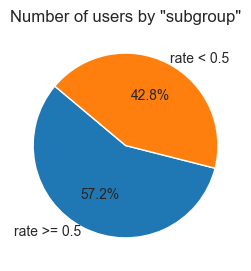

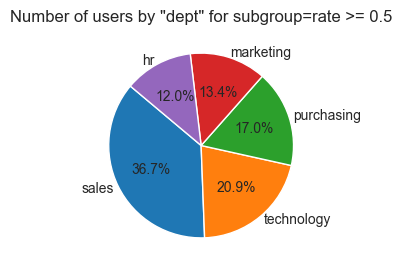

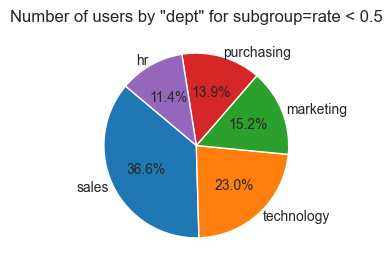

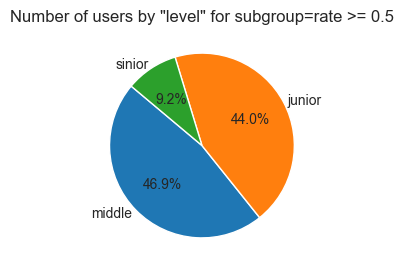

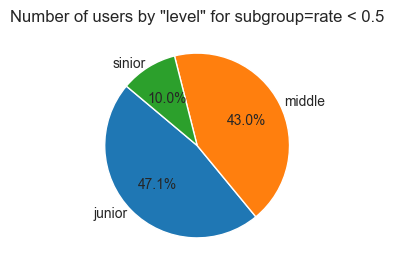

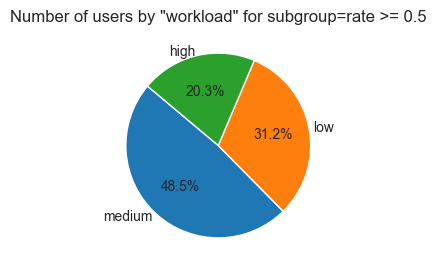

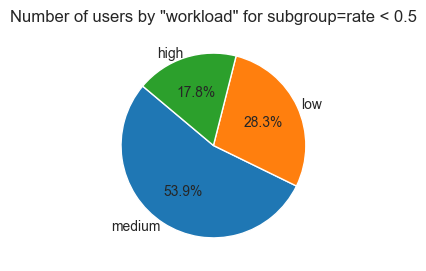

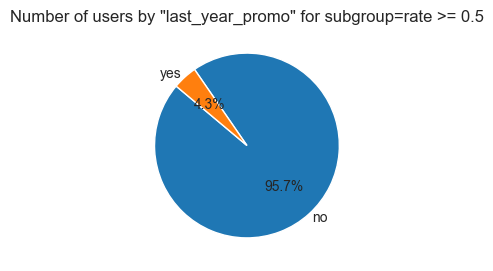

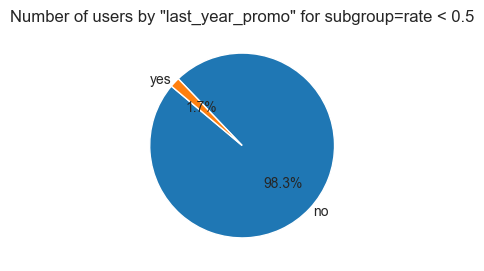

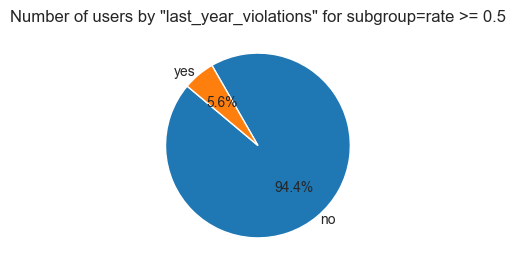

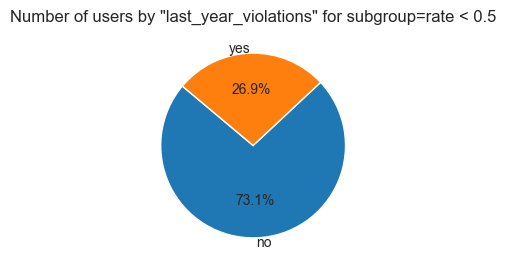

In [27]:
cat_plots(rate_df, rate_cat, group='job_satisfaction_rate')

When dividing into groups by satisfaction level at 0.5, the ratio of employees with ≥0.5 and <0.5 is approximately 60/40. The most common departments are sales and technology. About half of the employees are junior specialists. Also, 50% are employees with a medium workload. In the group with satisfaction level ≥0.5, 4.3% of employees were promoted last year. In the <0.5 group — 1.7%. In the ≥0.5 group, a smaller percentage of employees violated the contract rules — 5.6%. In the <0.5 group, such employees make up 26.9%.

In [28]:
rate_num

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64

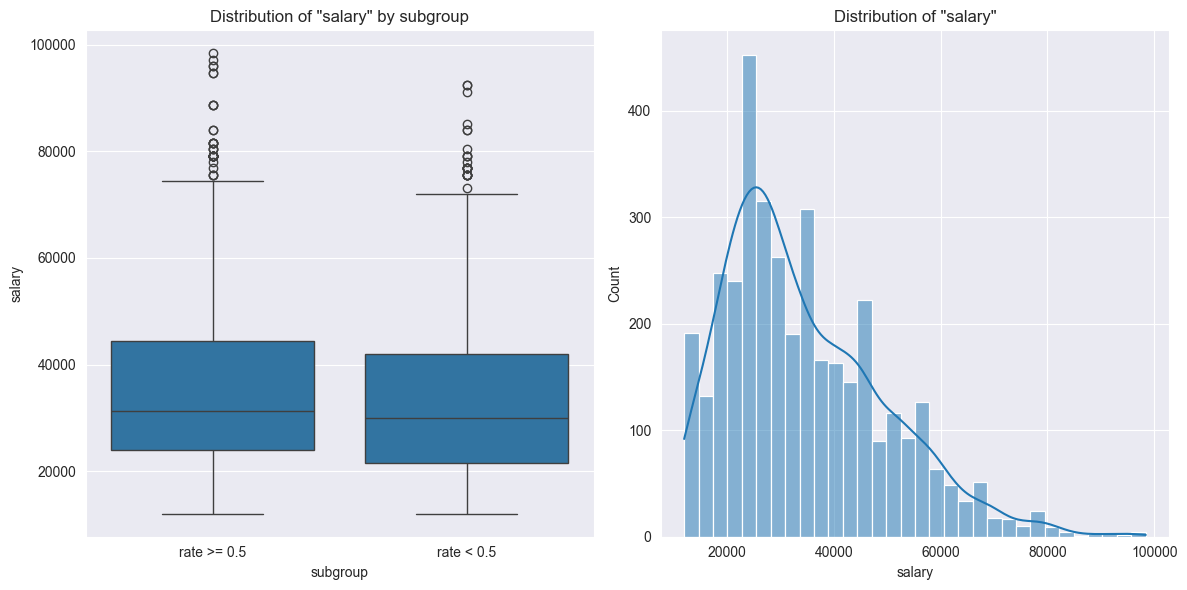

count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

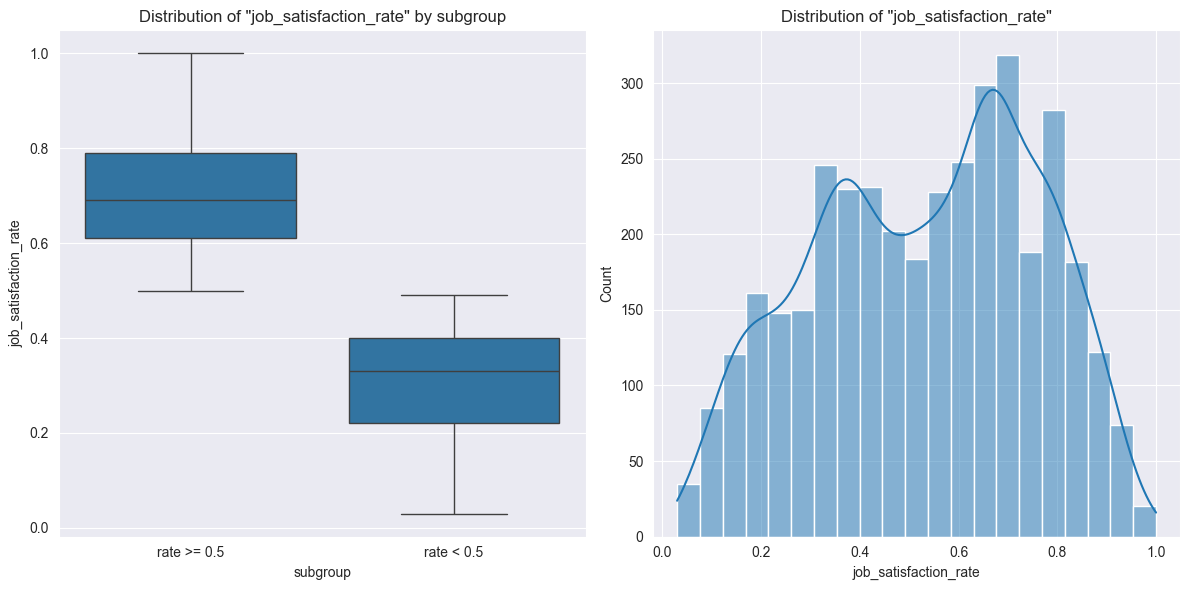

In [29]:
num_plots(rate_df, ['salary', 'job_satisfaction_rate'], group='job_satisfaction_rate')

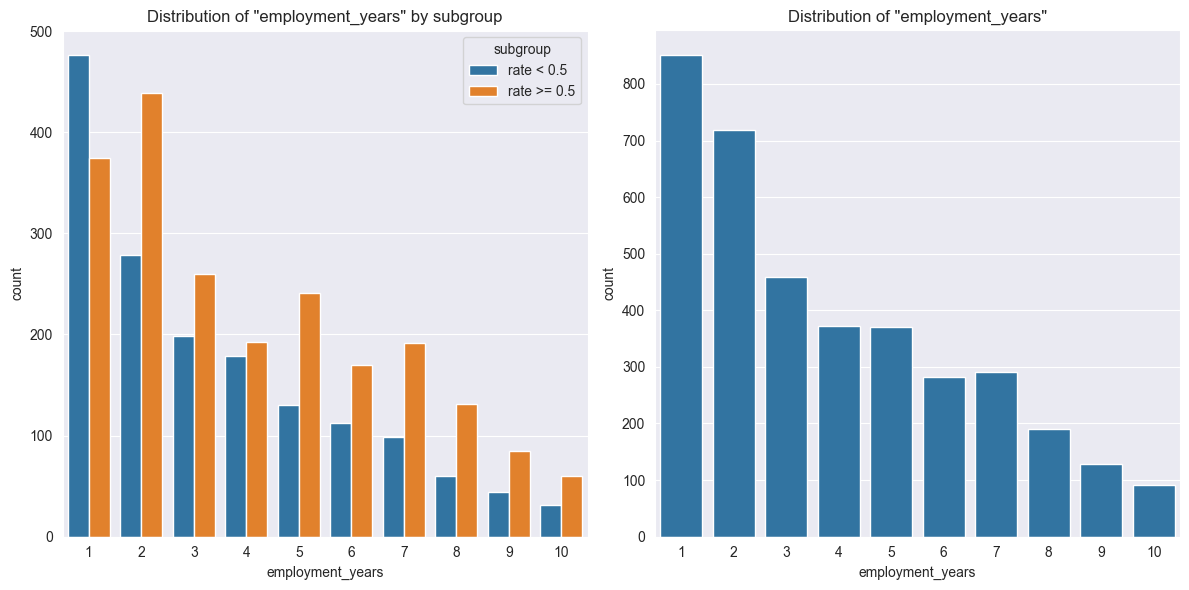

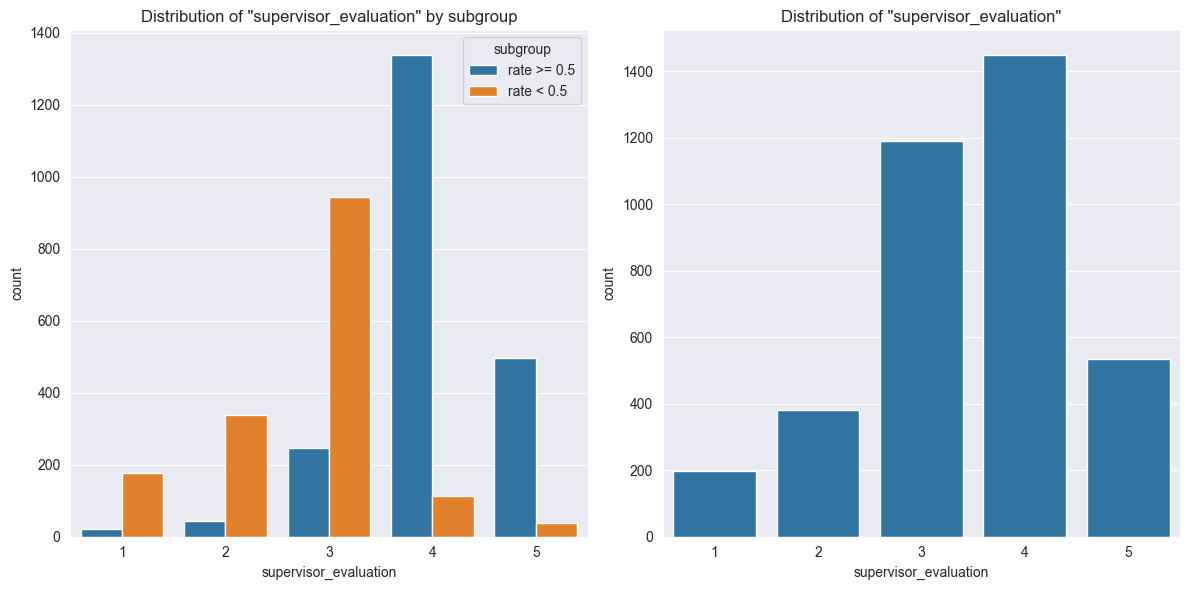

In [30]:
discrete_plots(rate_df, ['employment_years', 'supervisor_evaluation'], group='job_satisfaction_rate')

By number of years in the company, a decreasing trend is visible — there are more new employees.
Work quality evaluation is on average higher for employees in the ≥0.5 group (the score is 4). For the <0.5 group, the score lies in the range of 2–3.
The salaries of both groups are distributed approximately the same. The maximum is 98,400. The average is around 34,000.

The distribution of satisfaction scores resembles a normal distribution with 2 peaks — around 0.4 and 0.7.

In [31]:
#deleting subgroups since we don't need them anymore
rate_df.drop(columns='subgroup', inplace=True)
rate_df.head(2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76


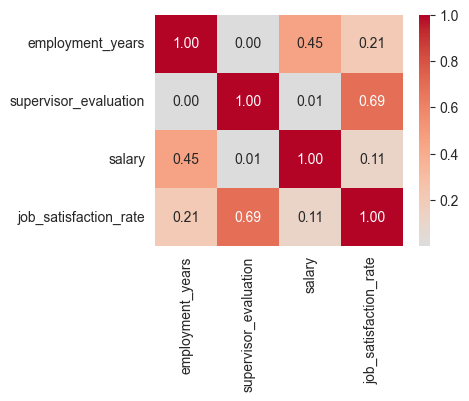

In [32]:
plt.figure(figsize=(4, 3))
sns.heatmap(rate_df[rate_num].corr(method='pearson'), fmt='.2f', cmap='coolwarm', center=0, annot=True)
plt.show()

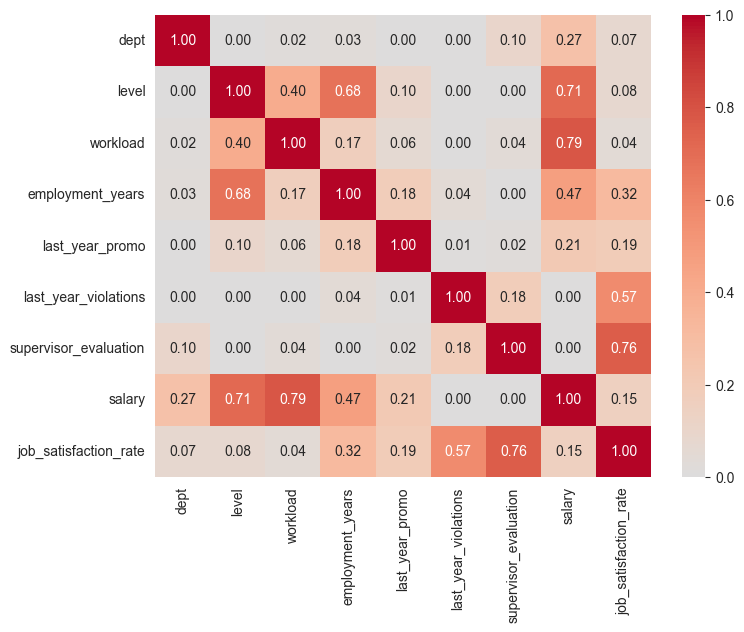

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(rate_df.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), fmt='.2f', cmap='coolwarm', center=0, annot=True)
plt.show()

There is a correlation between supervisor evaluation and satisfaction level, between job level and work experience, and between job level and salary. But all metrics do not exceed 0.8, so we leave everything as is.

In [34]:
test_rate_merged = features_df.merge(test_rate_df, on='id')
test_rate_merged.set_index('id', inplace=True)
test_rate_merged.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


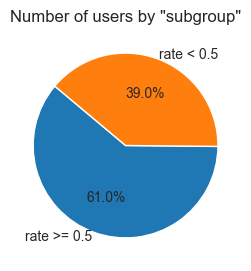

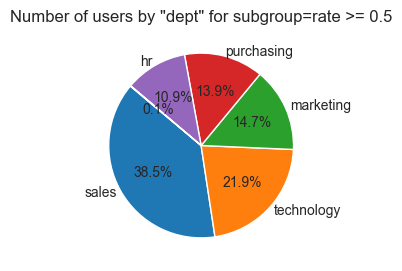

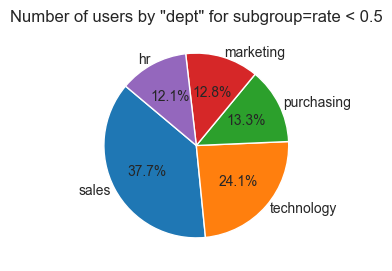

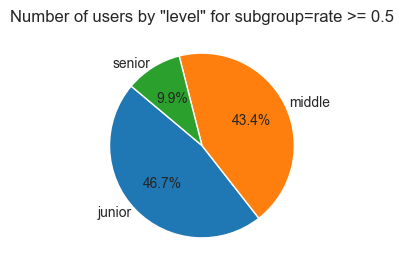

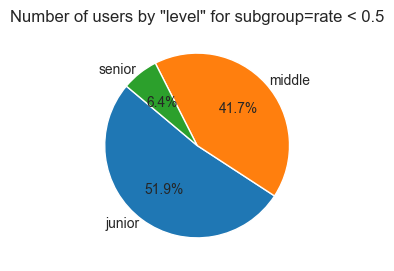

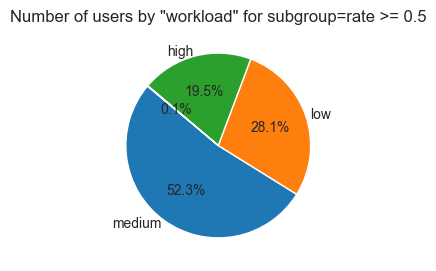

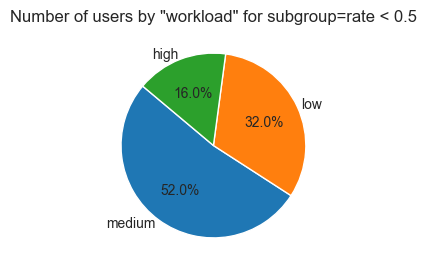

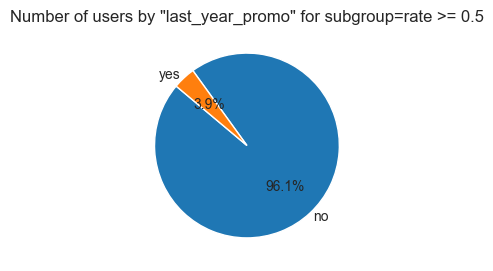

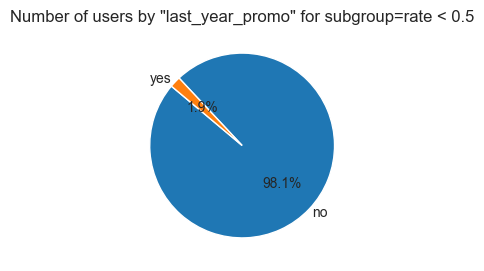

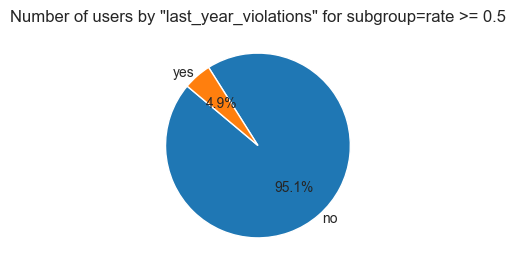

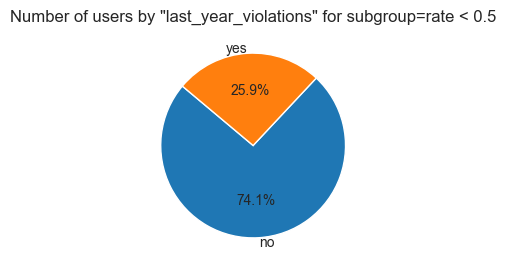

In [35]:
cat_plots(test_rate_merged, rate_cat, group='job_satisfaction_rate')

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

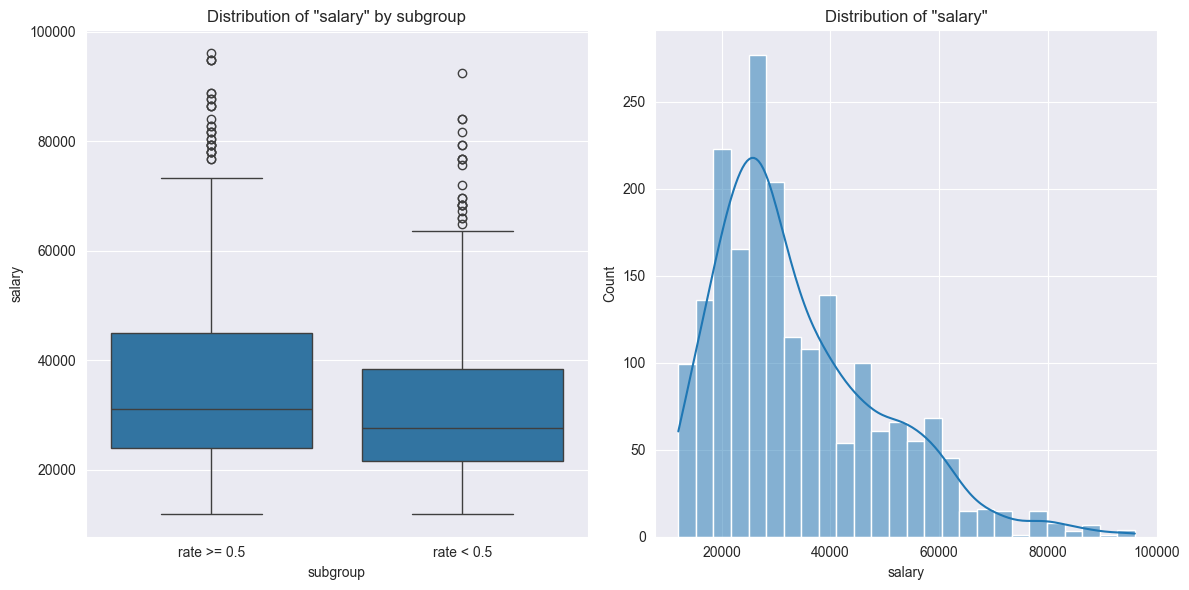

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

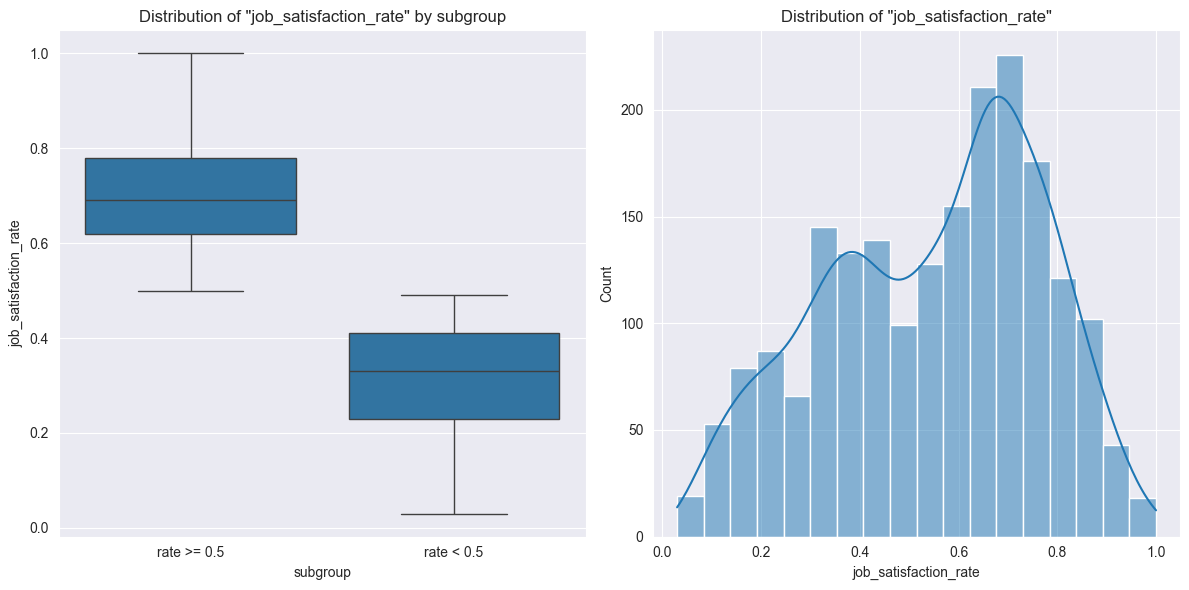

In [36]:
num_plots(test_rate_merged, ['salary', 'job_satisfaction_rate'], group='job_satisfaction_rate')

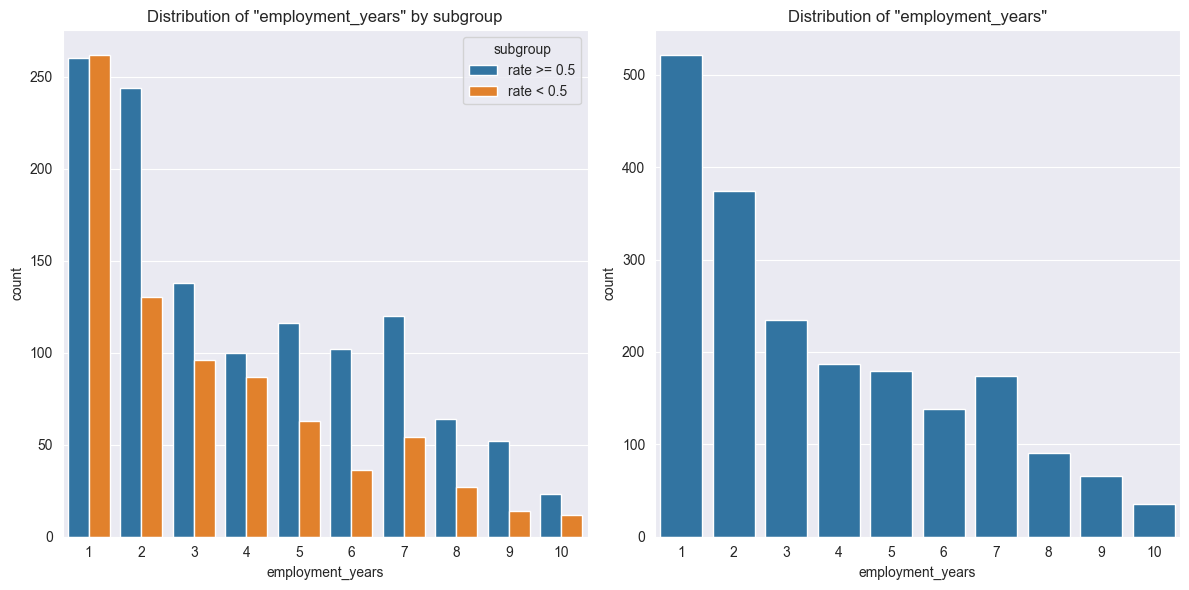

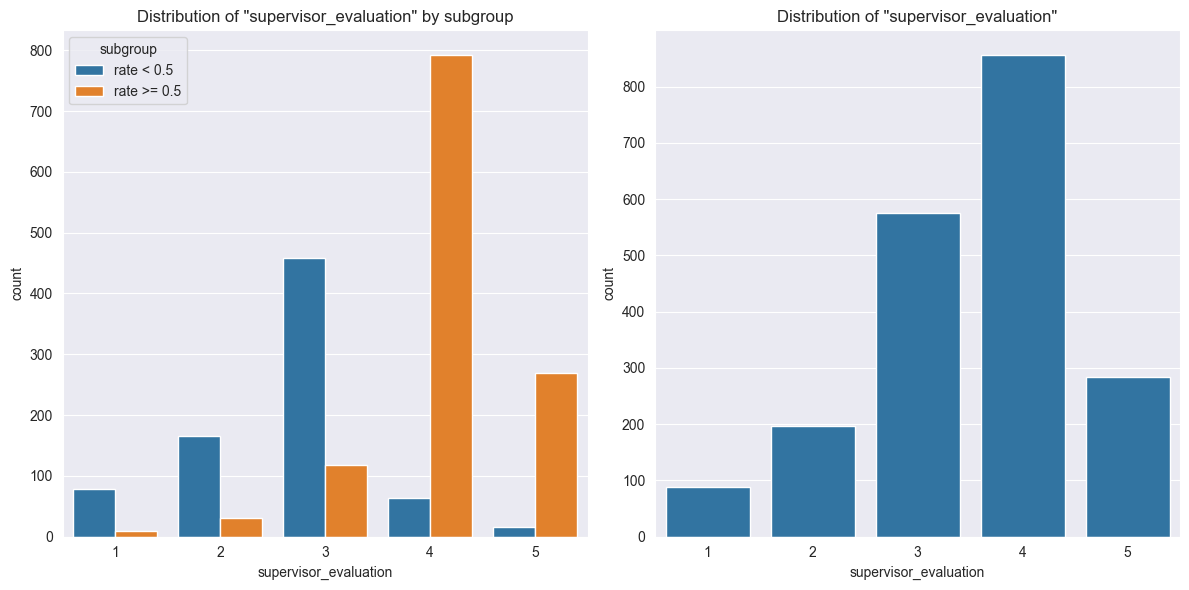

In [37]:
discrete_plots(test_rate_merged, ['employment_years', 'supervisor_evaluation'], group='job_satisfaction_rate')

In [38]:
test_rate_merged.drop(columns='subgroup', inplace=True)
test_rate_merged.head(2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72


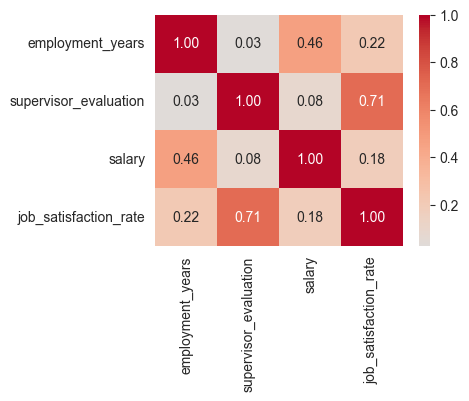

In [39]:
plt.figure(figsize=(4, 3))
sns.heatmap(test_rate_merged[rate_num].corr(method='pearson'), fmt='.2f', cmap='coolwarm', center=0, annot=True)
plt.show()

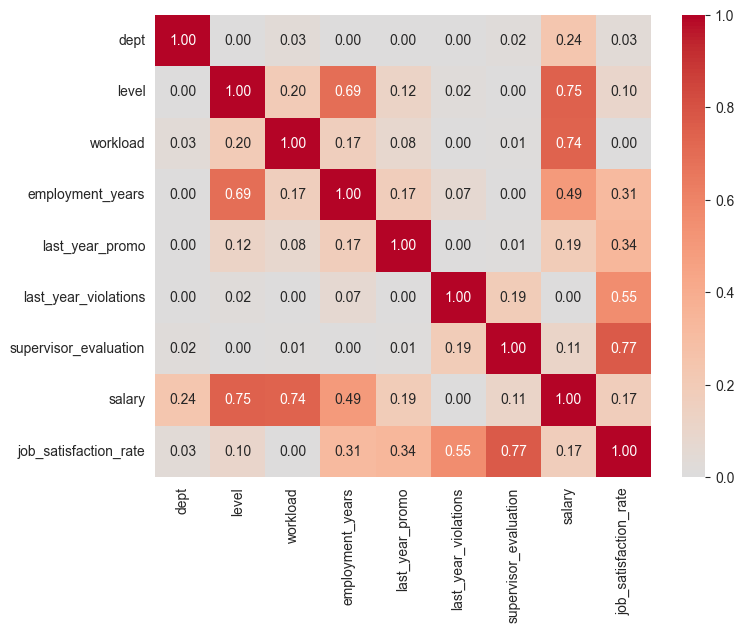

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(test_rate_merged.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), fmt='.2f', cmap='coolwarm', center=0, annot=True)
plt.show()

No critical discrepancies were found between the training and test data.

### Data preparation
The data is prepared in a pipeline

### Model training

Training of two models: one — linear, the other — decision tree.

In [41]:
def smape_metric(y_true, y_pred):
    metric=np.mean( 
            2 * np.abs(y_pred - y_true) / 
            (np.abs(y_pred) + np.abs(y_true)) 
        )*100
    return metric
    
smape_score = make_scorer(smape_metric, greater_is_better=False)

In [42]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'supervisor_evaluation', 'employment_years']

In [43]:
y_train = rate_df['job_satisfaction_rate']
X_train = rate_df.drop(['job_satisfaction_rate'], axis=1)

In [44]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleImputer_before_ohe_blank', 
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [45]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleImputer_before_ord_blank', 
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [46]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [47]:
final_p = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [48]:
parameters = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [RandomForestRegressor(
            random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 150],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],        
    }
]

In [49]:
search = GridSearchCV(
    final_p, 
    parameters,
    n_jobs=-1,
    cv=5, 
    scoring = smape_score,
    error_score='raise'
)

In [50]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe_nan',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('simpleImputer_before_ohe_blank',
                                                                                          SimpleImputer(missing_values=' ',
                                                                                                        strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [RandomForestRegressor(random_state=42)],
                          'models__max_depth': [None, 2, 3, 4, 5, 6],
                          'models__n_estimators': [50, 100, 150],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape_metric, greater_is_better=False, response_method='predict'))

In [51]:
results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,param_models__max_depth,param_models__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.624045,0.017636,0.024115,0.002492,RandomForestRegressor(random_state=42),MinMaxScaler(),None,150.0,{'models': RandomForestRegressor(random_state=...,-13.981779,-12.674030,-14.627412,-14.074222,-13.543366,-13.780162,0.651852,1
11,0.617767,0.010438,0.028955,0.003767,RandomForestRegressor(random_state=42),passthrough,None,150.0,{'models': RandomForestRegressor(random_state=...,-13.987849,-12.656535,-14.642888,-14.111004,-13.605659,-13.800787,0.661475,2
7,0.419503,0.008033,0.017620,0.001518,RandomForestRegressor(random_state=42),MinMaxScaler(),None,100.0,{'models': RandomForestRegressor(random_state=...,-14.049249,-12.719558,-14.711162,-14.024306,-13.509896,-13.802834,0.662439,3
8,0.419977,0.015095,0.020331,0.004479,RandomForestRegressor(random_state=42),passthrough,None,100.0,{'models': RandomForestRegressor(random_state=...,-14.067722,-12.694802,-14.727984,-14.064613,-13.578653,-13.826755,0.673755,4
9,0.609908,0.005642,0.031063,0.005220,RandomForestRegressor(random_state=42),StandardScaler(),None,150.0,{'models': RandomForestRegressor(random_state=...,-14.067492,-12.692491,-14.704387,-14.096445,-13.615243,-13.835212,0.668111,5
6,0.430844,0.008054,0.023433,0.002473,RandomForestRegressor(random_state=42),StandardScaler(),None,100.0,{'models': RandomForestRegressor(random_state=...,-14.134051,-12.731828,-14.785051,-14.043244,-13.597952,-13.858425,0.679092,6
4,0.231117,0.012775,0.013823,0.004570,RandomForestRegressor(random_state=42),MinMaxScaler(),None,50.0,{'models': RandomForestRegressor(random_state=...,-14.138851,-12.646407,-14.794342,-14.110040,-13.626387,-13.863205,0.712826,7
5,0.217252,0.006018,0.010373,0.001046,RandomForestRegressor(random_state=42),passthrough,None,50.0,{'models': RandomForestRegressor(random_state=...,-14.173479,-12.618294,-14.794809,-14.165185,-13.702149,-13.890783,0.724884,8
3,0.208067,0.008656,0.013404,0.004437,RandomForestRegressor(random_state=42),StandardScaler(),None,50.0,{'models': RandomForestRegressor(random_state=...,-14.250867,-12.653389,-14.843412,-14.133010,-13.731550,-13.922446,0.727643,9
55,0.303591,0.019014,0.012562,0.000844,RandomForestRegressor(random_state=42),MinMaxScaler(),6,150.0,{'models': RandomForestRegressor(random_state=...,-18.707459,-17.551347,-19.163983,-18.880469,-18.265487,-18.513749,0.562612,10


The best model -  RandomForestRegressor.

In [52]:
print(search.best_params_, (-1)*search.best_score_)

{'models': RandomForestRegressor(random_state=42), 'models__max_depth': None, 'models__n_estimators': 150, 'preprocessor__num': MinMaxScaler()} 13.780161807560878


Model performance evaluation on test data.

In [53]:
best_model = search.best_estimator_

In [54]:
X_test = test_rate_merged.drop('job_satisfaction_rate', axis=1)
y_test = test_rate_merged['job_satisfaction_rate']

In [55]:
y_pred = best_model.predict(X_test)
y_pred

array([0.8592619 , 0.6824226 , 0.65520661, ..., 0.22422389, 0.51442778,
       0.61912778], shape=(2000,))

In [56]:
print('SMAPE test:', (-1)*smape_score(best_model, X_test, y_test))

SMAPE test: 13.03688096148743


In [57]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train, y_train)
print('SMAPE test, DummyRegressor:', (-1)*smape_score(dummy_regressor, X_test, y_test))

SMAPE test, DummyRegressor: 38.26225790202237


The metric value differs significantly.

Feature importance analysis.

In [58]:
preprocessor = search.best_estimator_.named_steps['preprocessor']

In [59]:
X_train_2 = preprocessor.fit_transform(X_train)
X_test_2 = preprocessor.transform(X_test)

In [60]:
preprocessor_ohe = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = preprocessor_ohe.get_feature_names_out()
ohe_feature_names

array(['x0_marketing', 'x0_purchasing', 'x0_sales', 'x0_technology',
       'x1_yes', 'x2_yes'], dtype=object)

In [61]:
features = list(ohe_feature_names) + list(ord_columns) + num_columns
features

['x0_marketing',
 'x0_purchasing',
 'x0_sales',
 'x0_technology',
 'x1_yes',
 'x2_yes',
 'level',
 'workload',
 'salary',
 'supervisor_evaluation',
 'employment_years']

In [62]:
X_test_2 = pd.DataFrame(X_test_2, columns=features)
X_test_2.head(2)

,x0_marketing,x0_purchasing,x0_sales,x0_technology,x1_yes,x2_yes,level,workload,salary,supervisor_evaluation,employment_years
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.194444,1.00,0.111111
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.208333,0.75,0.000000


In [63]:
model = search.best_estimator_.named_steps['models']
explainer = shap.Explainer(model.predict, X_train_2)

In [64]:
shap_values = explainer(X_test_2[:200])

PermutationExplainer explainer: 201it [01:16,  2.34it/s]                         


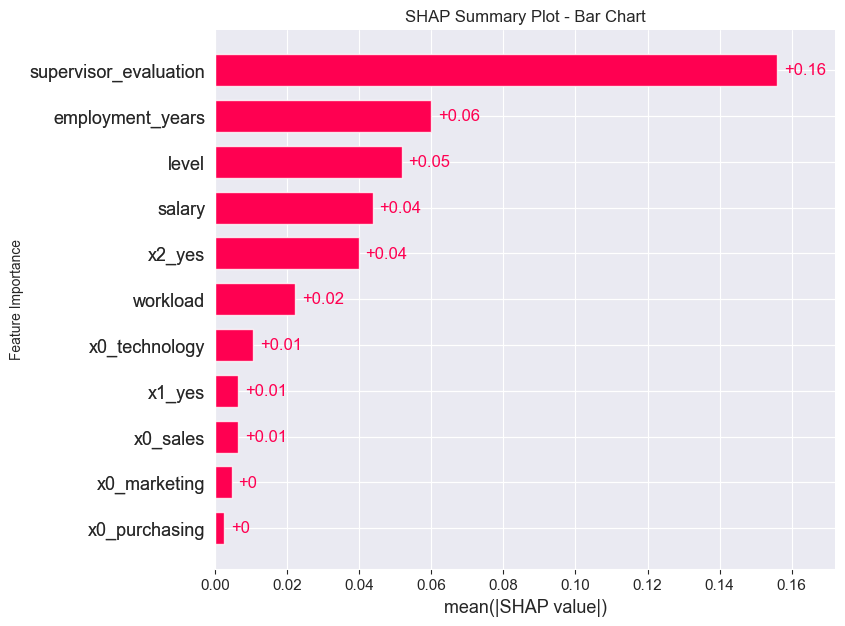

In [65]:
plt.title('SHAP Summary Plot - Bar Chart')
plt.ylabel('Feature Importance')
shap.plots.bar(shap_values, max_display=22)
plt.show()

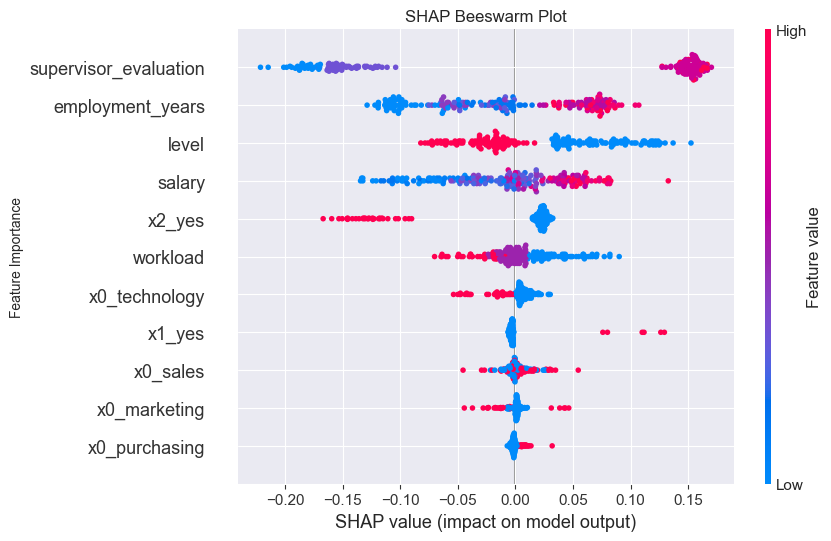

In [66]:
plt.title('SHAP Beeswarm Plot')
plt.ylabel('Feature Importance')
shap.plots.beeswarm(shap_values, max_display=22)
plt.show()

### Conclusion. Task 1.

The best result was achieved by grouping attributes as follows:

* OneHot Encoding — 'dept', 'last\_year\_promo', 'last\_year\_violations';
* Ordinal Encoding — 'level', 'workload';
* Numerical — 'salary', 'supervisor\_evaluation', 'employment\_years';

Best model:
`RandomForestRegressor(max_depth=15, n_estimators=150, random_state=42), 'models__max_depth': 15, 'models__n_estimators': 150, 'preprocessor__num': MinMaxScaler()`
SMAPE metric on training set = 13.75
SMAPE metric on test set = 12.32

The most important features for the model were supervisor evaluation, number of years at the company, and job level.

## Task 2

### Data Loading

In [67]:
quit_df = pd.read_csv('../datasets/train_quit.csv')
test_quit_df = pd.read_csv('../datasets/test_target_quit.csv')
features_df = pd.read_csv('../datasets/test_features.csv')

In [68]:
df_description(quit_df)

shape:  (4000, 10)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,0
id,0.000000
dept,0.000000
level,0.000000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000
quit,0.000000


In [69]:
df_description(test_quit_df)

shape:  (2000, 2)


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,0
id,0.000000
quit,0.000000


In [70]:
df_description(features_df)

shape:  (2000, 9)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,0
id,0.000000
dept,0.100000
level,0.050000
workload,0.000000
employment_years,0.000000
last_year_promo,0.000000
last_year_violations,0.000000
supervisor_evaluation,0.000000
salary,0.000000


The data types are all in order. Missing values will be filled in the pipeline.

In [71]:
quit_cat, quit_num = get_num_cat_attributes(quit_df)
quit_num.remove('id')
print(quit_cat, quit_num)

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit'] ['employment_years', 'supervisor_evaluation', 'salary']


Duplicate check

In [72]:
for attr in quit_cat:
    print(quit_df[attr].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [73]:
quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [74]:
quit_df.set_index('id', inplace=True)
quit_df.duplicated().sum()

np.int64(1413)

There are many duplicates. Since they appeared after removing the ID, these duplicates are likely different employees. For the model, we will need to remove such entries, but for data analysis they are useful, as they help to understand the distribution of attributes across all employees.

### Exploratory Data Analysis

#### Profile of a resigned employee
We will also look at the data in the context of the target feature. But since this is a classification task, we will slightly adjust the definition of functions.

In [75]:
def cat_plots_classification(df, columns, group=None, min_percent=5):
    if group is None:
        for col in columns:
            counts = df[col].value_counts()
            labels = counts.index.tolist()
            sizes = counts.values.tolist()

            plt.figure(figsize=(3, 3))
            plt.pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p) if p >= min_percent else '', startangle=140)
            plt.axis('equal')

            plt.title(f'Number of users by "{col}"')
            plt.show()
    else:
        if group in columns:
            columns.remove(group)
        unique_values = df[group].unique()
        labels_target, sizes_target = df[group].value_counts().index.tolist(), df[group].value_counts().values.tolist()
        plt.figure(figsize=(5, 5))
        plt.pie(sizes_target, labels=labels_target, autopct='%1.1f%%', startangle=140, labeldistance=1.05)
        plt.title(f'Number of users by "{group}"')
        plt.show()
        for col in columns:
            for value in unique_values:
                plt.figure(figsize=(5, 5))
                subset_df = df[df[group] == value]
                counts = subset_df[col].value_counts()
                labels, sizes = counts.index.tolist(), counts.values.tolist()

                plt.pie(sizes, labels=[f'{label} ({sizes[i]})' if sizes[i]/sum(sizes)*100 >= min_percent else label for i, label in enumerate(labels)], autopct=lambda p: '{:.1f}%'.format(p) if p >= min_percent else '', startangle=140, labeldistance=1.05)
                plt.title(f'Number of users by "{col}" for {group}={value}')
                plt.show()

In [76]:
def num_plots_classification(df, columns, group=None):
    for col in columns:
        display(df[col].describe())
        plt.figure(figsize=(12, 6))
        if group is not None:
            plt.subplot(1, 2, 1)
            sns.boxplot(x=group, y=col, data=df)
            plt.title(f'Distribution of "{col}" by {group}')

            plt.subplot(1, 2, 2)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of "{col}"')

        else:
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df[col], showfliers=False)
            plt.title(f'Distribution of "{col}"')

            plt.subplot(1, 2, 2)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of "{col}"')

        plt.tight_layout()
        plt.show()
        
        
def discrete_plots_classification(df, columns, group=None):
    for col in columns:
        plt.figure(figsize=(12, 6))
        if group is None:
            plt.subplot(1, 2, 1)
            sns.boxplot(y=df[col], showfliers=False)
            plt.title(f'Distribution of "{col}"')

            plt.subplot(1, 2, 2)
            sns.countplot(x=col, data=df)
            plt.title(f'Distribution of "{col}"')
        else:
            if isinstance(df[group].iloc[0], (int, float)):
                df['subgroup'] = np.where(df[group] == 'yes', 'quit=yes', 'quit=no')
                group = 'subgroup'

            plt.subplot(1, 2, 1)
            sns.countplot(x=col, hue=group, data=df)
            plt.title(f'Distribution of "{col}" by {group}')

            plt.subplot(1, 2, 2)
            sns.countplot(x=col, data=df)
            plt.title(f'Distribution of "{col}"')


        plt.tight_layout()
        plt.show()

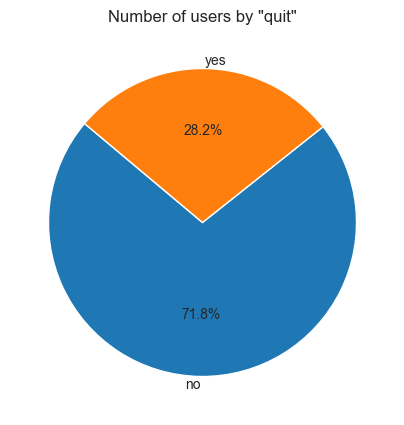

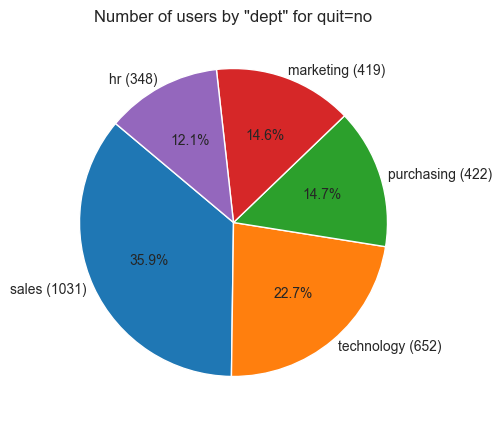

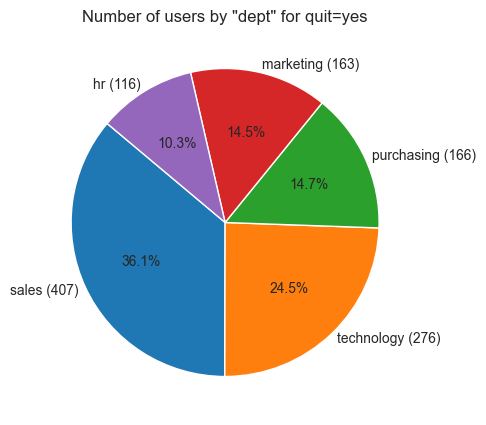

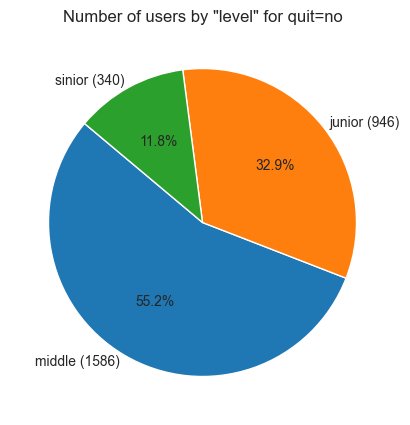

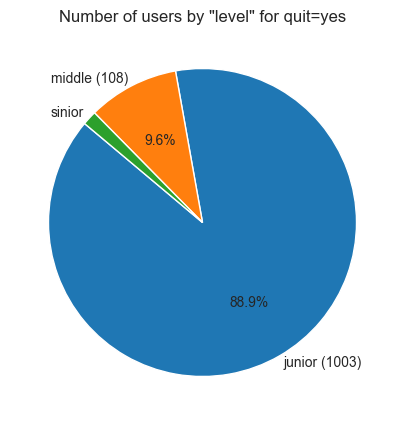

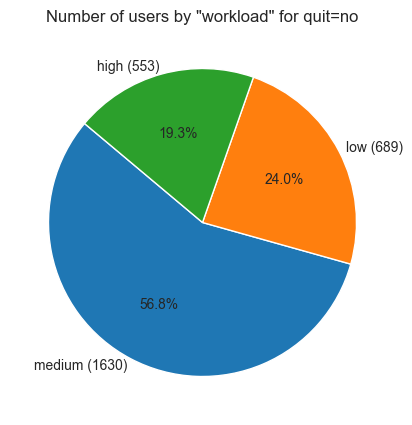

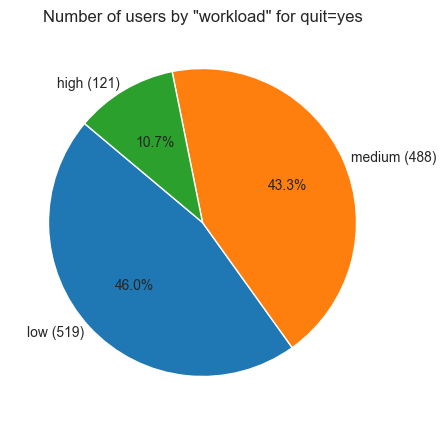

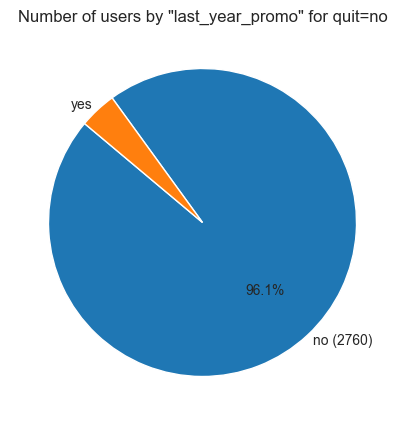

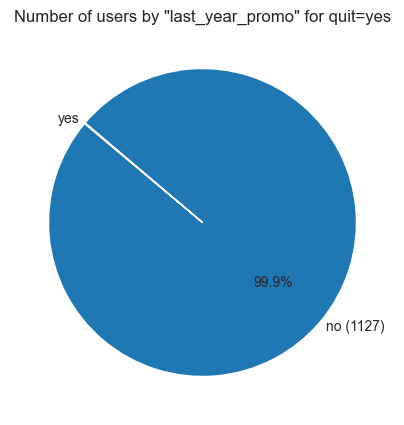

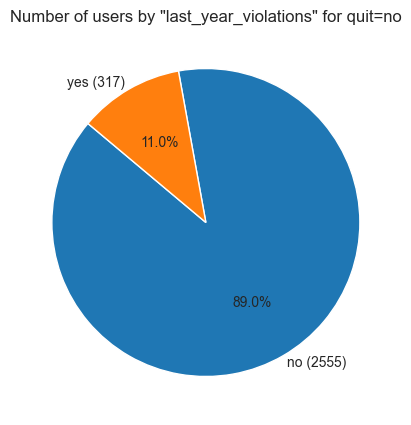

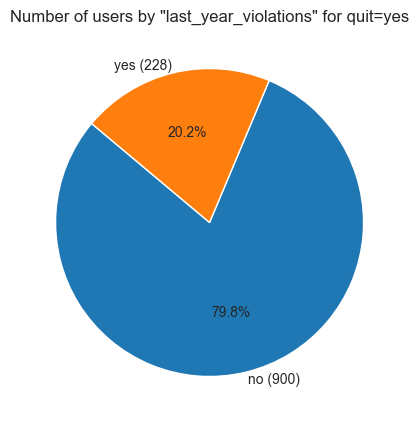

In [77]:
cat_plots_classification(quit_df, quit_cat, group='quit')

The ratio of resigned to non-resigned employees is approximately 30/70.
The departments where employees from both groups work do not differ significantly. Sales and technology are the most common.
Among resigned employees, junior-level specialists dominate — almost 90%. Also, 90% in total are employees with high or medium workload. Among non-resigned employees, the majority are middle-level, and 90% have medium or low workload.
Almost all resigned employees did not receive a promotion last year.

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

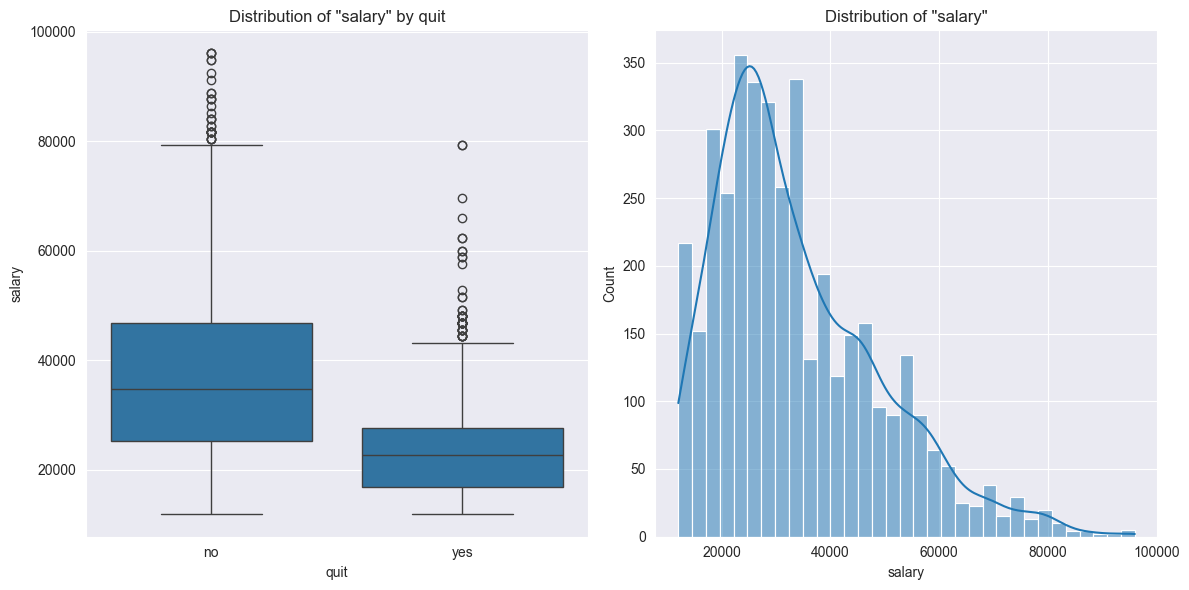

In [78]:
num_plots_classification(quit_df, ['salary'], group='quit')

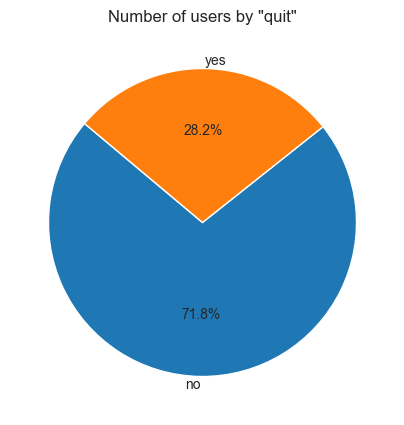

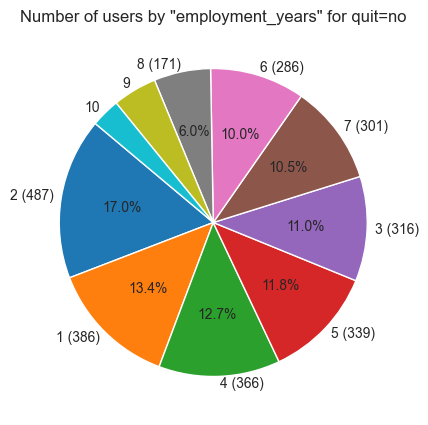

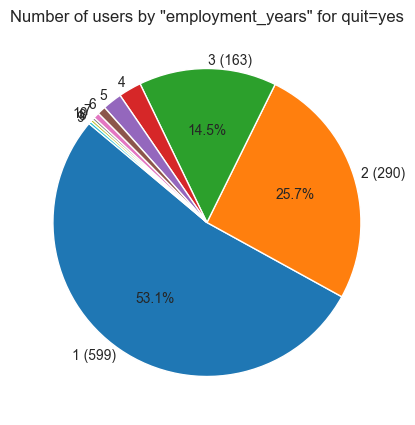

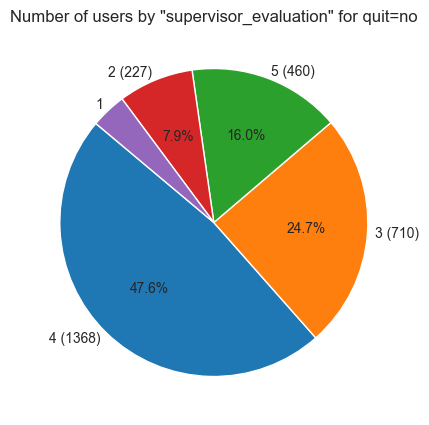

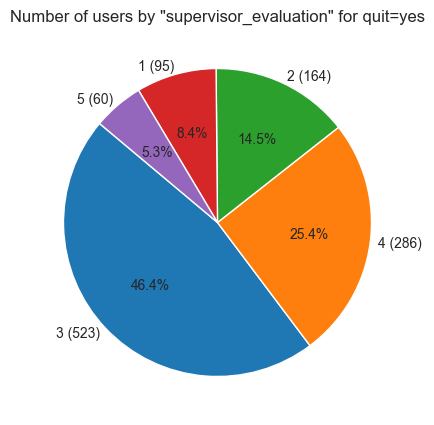

In [79]:
cat_plots_classification(quit_df, ['employment_years', 'supervisor_evaluation'], group='quit')

Resigned employees are mostly those who worked in the company for a short time. The remaining employees have been working on average for 4 years.
Supervisor evaluation is on average 3.5 for both groups.
The average salary of remaining employees is significantly higher than that of resigned ones — the difference is almost 10,000.

#### Distribution of `job_satisfaction_rate`

Analysts claim that an employee's job satisfaction level affects whether they resign. Let's verify this claim: visualize and compare the distributions of the `job_satisfaction_rate` feature for resigned and retained employees. Use the data from the test set with both target labels.

In [80]:
# merging only the data we need
rate_quit_df = test_quit_df.merge(test_rate_df, on='id')

In [81]:
rate_quit_df.head()

,id,quit,job_satisfaction_rate
0,999029,yes,0.35
1,372846,no,0.21
2,726767,no,0.73
3,490105,no,0.62
4,416898,yes,0.57


       count      mean       std   min   25%   50%     75%   max
quit                                                            
no    1436.0  0.612040  0.199367  0.03  0.50  0.66  0.7600  1.00
yes    564.0  0.387713  0.185784  0.04  0.24  0.37  0.4925  0.97


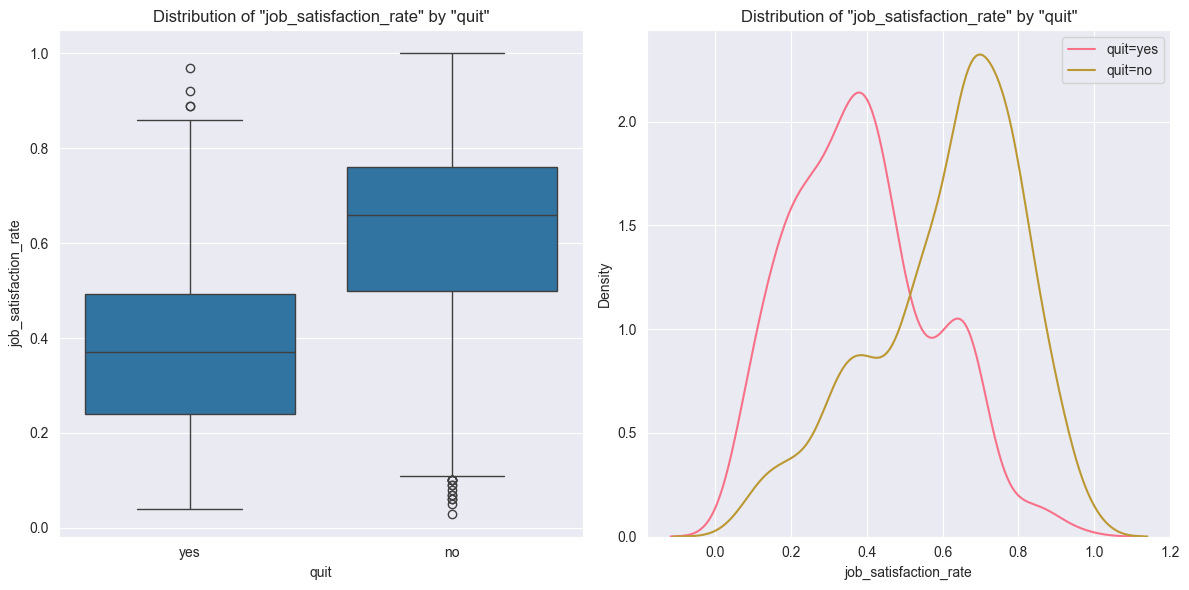

In [82]:
describe_by_quit = rate_quit_df.groupby('quit')['job_satisfaction_rate'].describe()
print(describe_by_quit)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='quit', y='job_satisfaction_rate', data=rate_quit_df)
plt.title(f'Distribution of "job_satisfaction_rate" by "quit"')


plt.subplot(1, 2, 2)
quit_status_mapping = {'yes': 0, 'no': 1} 
# for quit_status in rate_quit_df['quit'].unique():
#     sns.histplot(rate_quit_df[rate_quit_df['quit'] == quit_status]['job_satisfaction_rate'], \
#                  kde=True, label=f'quit={quit_status}', alpha=0.5, \
#                  color=sns.color_palette('husl')[quit_status_mapping[quit_status]])
for quit_status in rate_quit_df['quit'].unique():
    sns.kdeplot(rate_quit_df[rate_quit_df['quit'] == quit_status]['job_satisfaction_rate'], \
                label=f'quit={quit_status}', color=sns.color_palette('husl')[quit_status_mapping[quit_status]])

plt.title(f'Distribution of "job_satisfaction_rate" by "quit"')
plt.legend()

plt.tight_layout()
plt.show()

The average job satisfaction level of retained employees is significantly higher — 0.61 compared to 0.38. The histogram also shows that the distribution for resigned employees is left-skewed, while for retained employees it is right-skewed.

In [83]:
rate_quit_df.head()

,id,quit,job_satisfaction_rate
0,999029,yes,0.35
1,372846,no,0.21
2,726767,no,0.73
3,490105,no,0.62
4,416898,yes,0.57


In [84]:
rate_yes = rate_quit_df.query('quit == "yes"')['job_satisfaction_rate']
rate_no = rate_quit_df.query('quit == "no"')['job_satisfaction_rate']

In [85]:
print(f'YES: len={len(rate_yes)}, var={np.var(rate_yes)}\nNO: len={len(rate_no)}, var={np.var(rate_no)}')

YES: len=564, var=0.034454520333484236
NO: len=1436, var=0.03971958332686742


Null hypothesis: the mean job satisfaction levels of the two groups are equal.
Alternative hypothesis: the mean job satisfaction level of employees who resign is lower than that of those who remain in the company. A one-sided hypothesis test is being conducted.

Since we are comparing the means of two populations, with sufficiently large samples and similar variance, we will use a t-test without the `equal_var=False` parameter.

In [86]:
alpha = 0.5 

results = st.ttest_ind(rate_yes, rate_no, alternative='less')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis. The average job satisfaction level of employees who resign is lower than that of employees who remain in the company.')
else:
    print('We do not reject the null hypothesis. The average job satisfaction levels of the two groups are equal.')

p-value: 6.1556103325868406e-105
We reject the null hypothesis. The average job satisfaction level of employees who resign is lower than that of employees who remain in the company.


### Adding a New Input Feature

Suppose `job_satisfaction_rate` and `quit` are indeed related, and you achieved the required metric value in the first task. Then add the `job_satisfaction_rate`, as predicted by the best model from Task 1, to the input features of Task 2.


In [87]:
# We will use the already predicted values, since the test datasets for Tasks 1 and 2 are the same.
test_rate_merged['rate_pred'] = y_pred
print(test_rate_merged.shape)
test_rate_merged.head(2)

(2000, 10)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,rate_pred
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,0.859262
686555,hr,junior,medium,1,no,no,4,30000,0.72,0.682423


In [88]:
# We will immediately add the target variable values to the table by merging on `id`, and remove the original `job_satisfaction_rate`.
test_quit_merged = test_rate_merged.merge(test_quit_df, on='id')
test_quit_merged.drop(columns=['job_satisfaction_rate'], inplace=True)
test_quit_merged.shape

(2000, 11)

In [89]:
test_quit_merged.set_index('id', inplace=True)
test_quit_merged.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,rate_pred,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.859262,no
686555,hr,junior,medium,1,no,no,4,30000,0.682423,no
467458,sales,middle,low,5,no,no,4,19200,0.655207,no
418655,sales,middle,low,6,no,no,4,19200,0.656565,no
789145,hr,middle,medium,5,no,no,5,40800,0.785111,no


In [90]:
quit_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [91]:
# leaving the features that we need for the 1st model
quit_to_predict_rate = quit_df.drop(columns=['quit'])
quit_to_predict_rate.head(2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000
814010,sales,junior,medium,2,no,no,4,27600


In [92]:
y_rate_pred = best_model.predict(quit_to_predict_rate)

Got the values of satisfaction rate for train data.

In [93]:
quit_df['rate_pred'] = y_rate_pred
quit_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,rate_pred
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.634611
814010,sales,junior,medium,2,no,no,4,27600,no,0.845452
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.378017
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.351313
910140,marketing,junior,medium,2,no,no,5,25200,no,0.755985


Train data - quit_df, and test data - test_quit_merged.

In [94]:
test_quit_merged.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,rate_pred,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.859262,no
686555,hr,junior,medium,1,no,no,4,30000,0.682423,no
467458,sales,middle,low,5,no,no,4,19200,0.655207,no
418655,sales,middle,low,6,no,no,4,19200,0.656565,no
789145,hr,middle,medium,5,no,no,5,40800,0.785111,no


In [95]:
quit_cat, quit_num = get_num_cat_attributes(test_quit_merged)

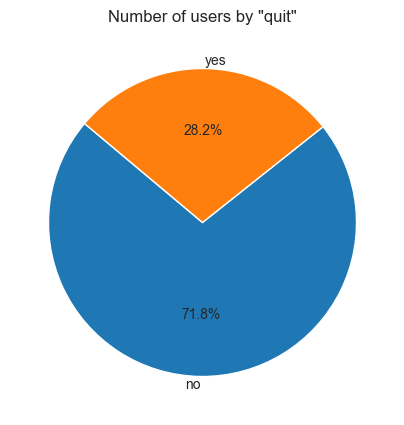

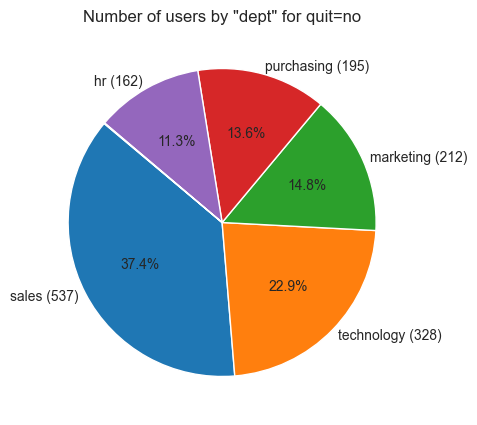

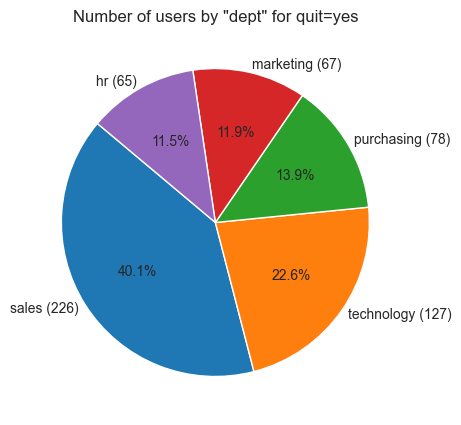

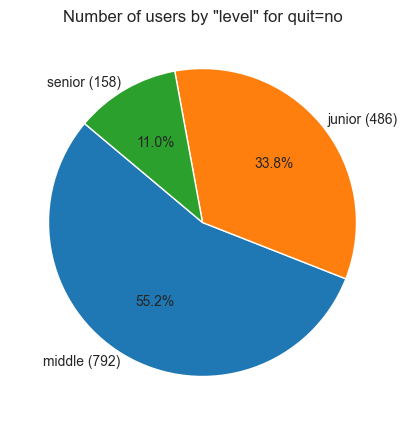

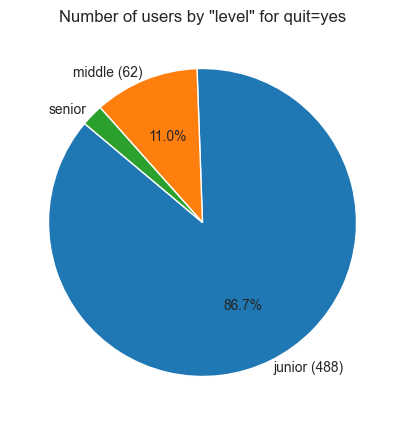

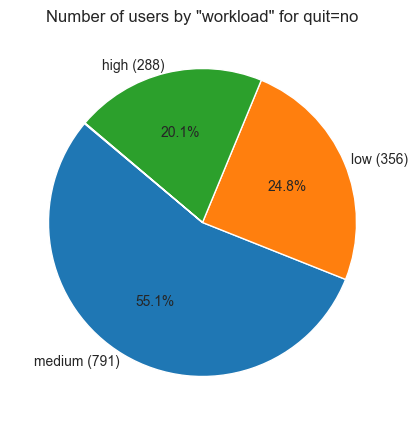

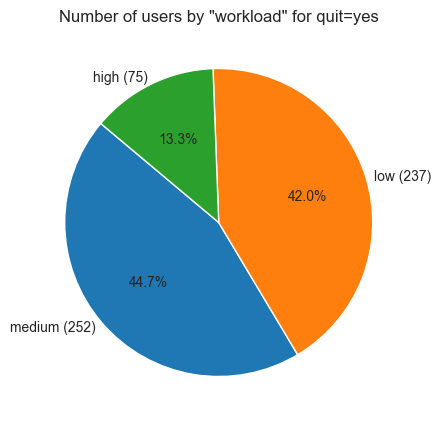

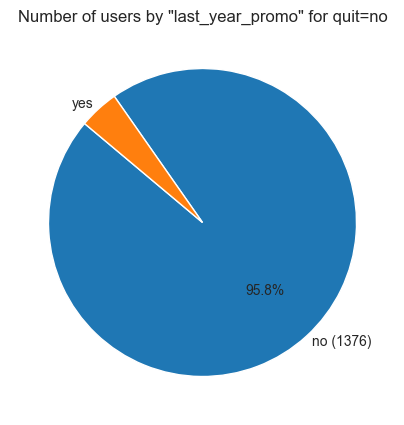

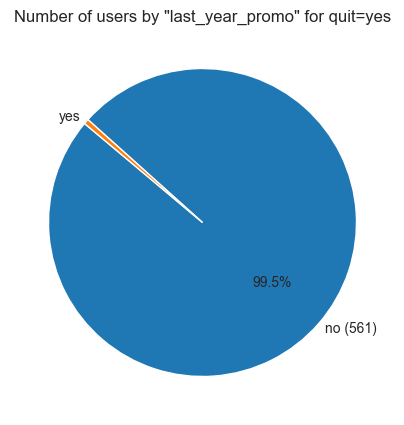

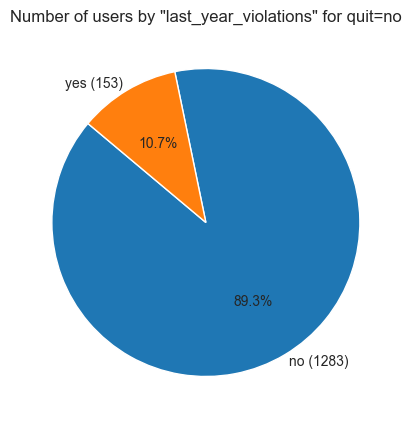

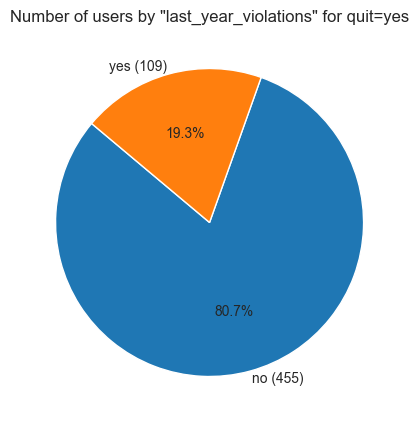

In [96]:
cat_plots_classification(test_quit_merged, quit_cat, group='quit')

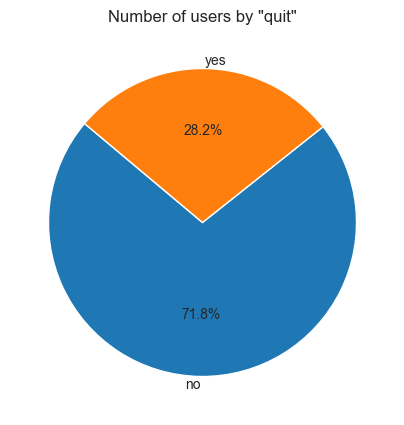

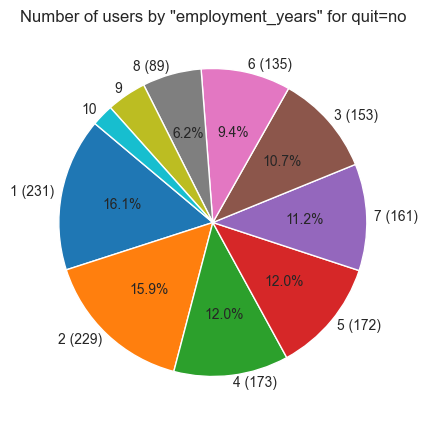

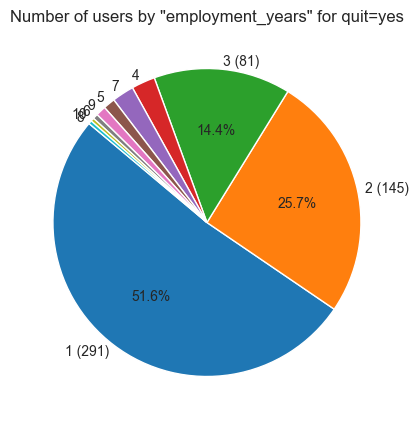

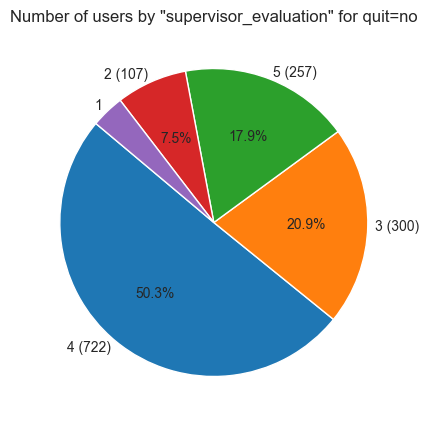

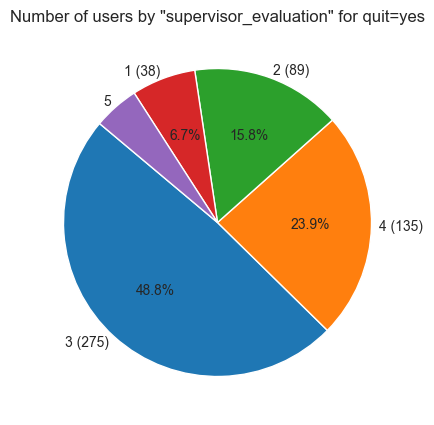

In [97]:
cat_plots_classification(test_quit_merged, ['employment_years', 'supervisor_evaluation'], group='quit')

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

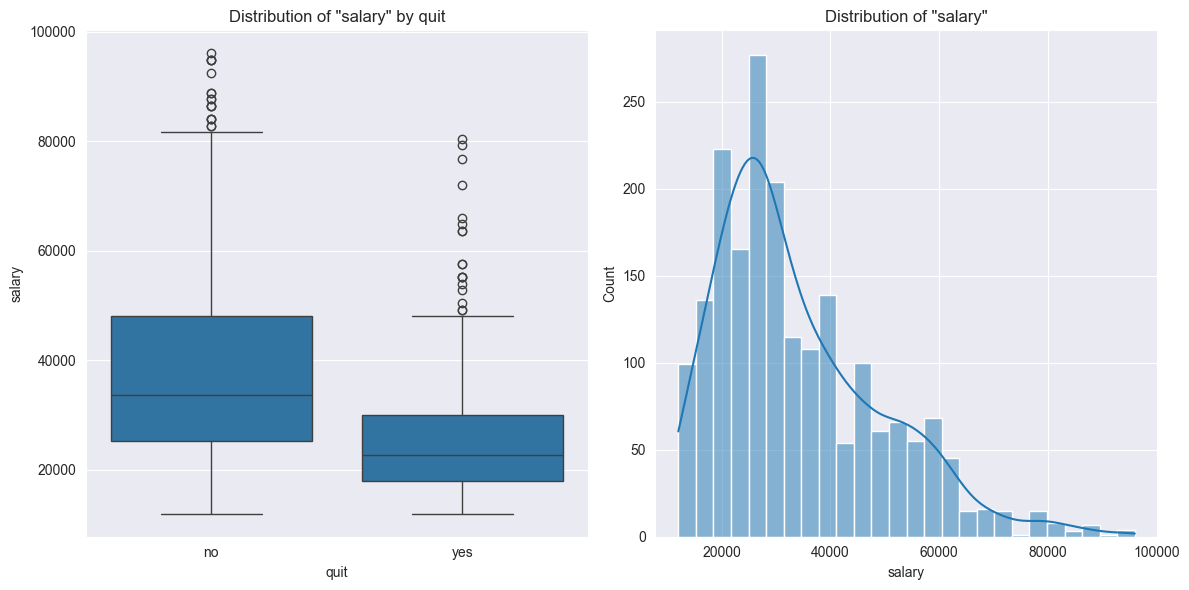

count    2000.000000
mean        0.557935
std         0.216440
min         0.062987
25%         0.363675
50%         0.601467
75%         0.722470
max         0.979033
Name: rate_pred, dtype: float64

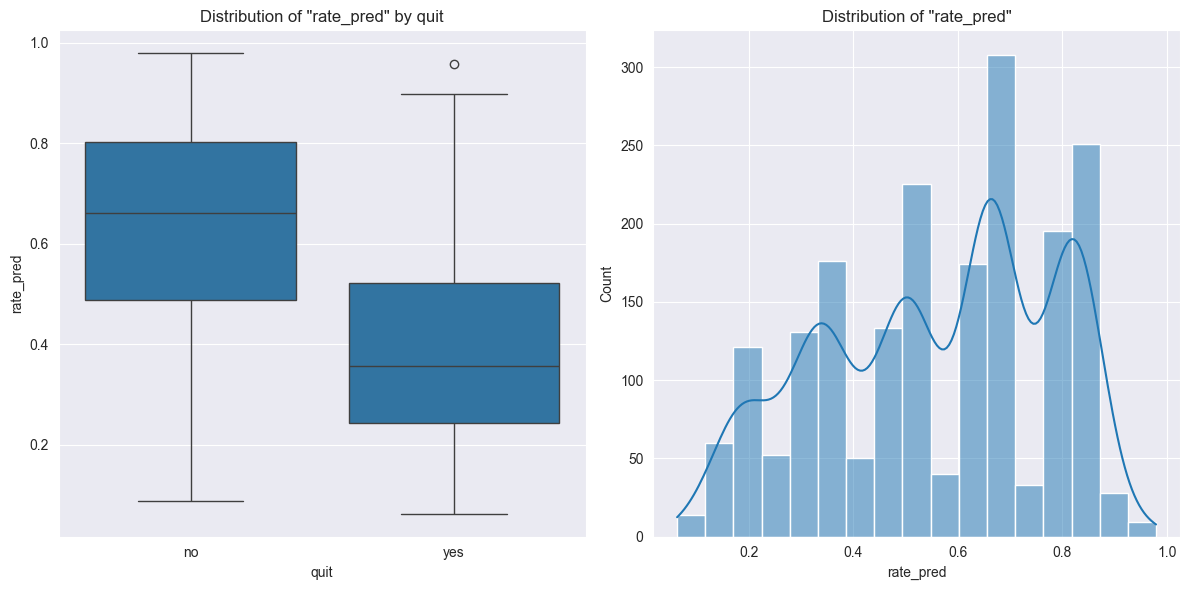

In [98]:
num_plots_classification(test_quit_merged, ['salary', 'rate_pred'], group='quit')

Analysis of the test data showed a similar distribution of values as in the training set.

With the exploratory data analysis complete, we can now remove duplicates from the training set to improve model training.

In [99]:
quit_df.duplicated().sum()

np.int64(1413)

In [100]:
quit_df.drop_duplicates(inplace=True)

### Data preparation
Same as in the task 1, data will be prepared in a pipeline

### Model training
Training of three models: `RandomForestClassifier`, `KNeighborsClassifier`, and `SVC`.

In [101]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'rate_pred']

In [102]:
quit_df['quit'].value_counts()

quit
no     1932
yes     655
Name: count, dtype: int64

There is a significant imbalance in the number of samples for the 'no' and 'yes' classes. Therefore, we will use `ImbPipeline` as the final pipeline.

In [103]:
X_train = quit_df.drop(['quit'], axis=1)

In [104]:
target = quit_df['quit']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)
pos_label = 'yes'
y_train = (y_encoded == label_encoder.transform([pos_label])[0]).astype(int)

In [105]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ohe_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleImputer_before_ohe_blank', 
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [106]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord_nan', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'simpleImputer_before_ord_blank', 
            SimpleImputer(missing_values=' ', strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [107]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [108]:
final_p = ImbPipeline(
    [
        ('preprocessor', data_preprocessor),
        ('smotetomek', SMOTETomek(sampling_strategy='auto', random_state=42)),
        ('models', RandomForestClassifier(random_state=RANDOM_STATE))
    ]
)

In [109]:
parameters = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'models': [KNeighborsClassifier(n_jobs=-1)],
        'models__n_neighbors': range(4, 6),
        'models__weights': ['uniform', 'distance'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [110]:
search = GridSearchCV(
    final_p, 
    parameters,
    n_jobs=-1,
    cv=5, 
    scoring = 'roc_auc',
    error_score='raise'
)

In [111]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ohe_nan',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('simpleImputer_before_ohe_blank',
                                                                                          SimpleImputer(missing_values=' ',
                                                                                                        strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop...
                         {'models': [KNeighborsClassifier(n_jobs=-1)],
                          'models__n_neighbors': range(4, 6),
                          'models__weights': ['uniform', 'distance'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVC(random_state=42)],
                          'models__kernel': ['poly', 'rbf', 'sigmoid'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [112]:
print(search.best_params_, search.best_score_)

{'models': RandomForestClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 3, 'models__n_estimators': 100, 'preprocessor__num': StandardScaler()} 0.9198817652902989


In [113]:
best_model_2 = search.best_estimator_

In [114]:
best_model_2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_before_ohe_blank',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_a...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary', 'rate_pred'])])),
                ('smotetomek', SMOTETomek(random_state=42)),
                ('models',
                 RandomForestClassifier(max_depth=6, max_features=3,
                                        random_state=42))])

In [115]:
test_quit_merged.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,rate_pred,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.859262,no
686555,hr,junior,medium,1,no,no,4,30000,0.682423,no
467458,sales,middle,low,5,no,no,4,19200,0.655207,no
418655,sales,middle,low,6,no,no,4,19200,0.656565,no
789145,hr,middle,medium,5,no,no,5,40800,0.785111,no


In [116]:
X_test = test_quit_merged.drop('quit', axis=1)
target = test_quit_merged['quit']
y_encoded = label_encoder.transform(target)
y_test = (y_encoded == label_encoder.transform([pos_label])[0]).astype(int)

In [117]:
y_pred_prob = best_model_2.predict_proba(X_test)
y_pred_one = y_pred_prob[:, 1]
print('Area under the ROC curve (AUC): ', roc_auc_score(y_test, y_pred_one))

Area under the ROC curve (AUC):  0.91921264742488


In [118]:
results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
display(results.head(5))
display(results.tail(5))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_models__n_estimators,param_preprocessor__num,param_models__n_neighbors,...,param_models__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
81,0.185977,0.007038,0.009729,0.001393,RandomForestClassifier(random_state=42),6.0,3.0,100.0,StandardScaler(),NaN,...,NaN,{'models': RandomForestClassifier(random_state...,0.919867,0.918250,0.925751,0.905707,0.929834,0.919882,0.008211,1
69,0.198861,0.015243,0.012006,0.003286,RandomForestClassifier(random_state=42),5.0,4.0,100.0,StandardScaler(),NaN,...,NaN,{'models': RandomForestClassifier(random_state...,0.919404,0.917421,0.924702,0.906736,0.929023,0.919457,0.007550,2
79,0.119496,0.009480,0.009077,0.003244,RandomForestClassifier(random_state=42),6.0,3.0,50.0,MinMaxScaler(),NaN,...,NaN,{'models': RandomForestClassifier(random_state...,0.918792,0.916632,0.924168,0.906617,0.930368,0.919316,0.007930,3
78,0.112745,0.007192,0.008183,0.001651,RandomForestClassifier(random_state=42),6.0,3.0,50.0,StandardScaler(),NaN,...,NaN,{'models': RandomForestClassifier(random_state...,0.919956,0.916869,0.925928,0.903759,0.929992,0.919301,0.009012,4
82,0.198338,0.016297,0.011907,0.003255,RandomForestClassifier(random_state=42),6.0,3.0,100.0,MinMaxScaler(),NaN,...,NaN,{'models': RandomForestClassifier(random_state...,0.916632,0.915192,0.924959,0.906518,0.930447,0.918750,0.008272,5


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_models__n_estimators,param_preprocessor__num,param_models__n_neighbors,...,param_models__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
149,0.026635,0.003516,0.021736,0.000766,KNeighborsClassifier(n_jobs=-1),NaN,NaN,NaN,passthrough,4.0,...,NaN,"{'models': KNeighborsClassifier(n_jobs=-1), 'm...",0.730872,0.763181,0.792370,0.802476,0.828966,0.783573,0.033730,161
155,0.024319,0.003869,0.020816,0.001887,KNeighborsClassifier(n_jobs=-1),NaN,NaN,NaN,passthrough,5.0,...,NaN,"{'models': KNeighborsClassifier(n_jobs=-1), 'm...",0.727755,0.761653,0.791609,0.797196,0.835077,0.782658,0.036041,162
162,0.141385,0.014157,0.019666,0.005465,SVC(random_state=42),NaN,NaN,NaN,StandardScaler(),NaN,...,sigmoid,"{'models': SVC(random_state=42), 'models__kern...",0.795915,0.757708,0.760462,0.766464,0.824151,0.780940,0.025535,163
164,0.127187,0.017899,0.016963,0.003328,SVC(random_state=42),NaN,NaN,NaN,passthrough,NaN,...,sigmoid,"{'models': SVC(random_state=42), 'models__kern...",0.706679,0.737430,0.739459,0.775343,0.331013,0.657985,0.164927,164
163,0.166633,0.017499,0.019459,0.001441,SVC(random_state=42),NaN,NaN,NaN,MinMaxScaler(),NaN,...,sigmoid,"{'models': SVC(random_state=42), 'models__kern...",0.755597,0.646202,0.643110,0.606514,0.630799,0.656445,0.051507,165


In [119]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train)

y_pred_prob = dummy_classifier.predict_proba(X_test)
y_pred_one = y_pred_prob[:, 1]
print('Area under the ROC curve (AUC): ', roc_auc_score(y_test, y_pred_one))

Area under the ROC curve (AUC):  0.5


With `DummyClassifier`, the metric value is very low.

### Feature importance analysis

In [120]:
preprocessor = best_model_2.named_steps['preprocessor']

In [121]:
X_train_2 = preprocessor.fit_transform(X_train)
X_test_2 = preprocessor.transform(X_test)

In [122]:
preprocessor_ohe = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = preprocessor_ohe.get_feature_names_out()
ohe_feature_names

array(['x0_marketing', 'x0_purchasing', 'x0_sales', 'x0_technology',
       'x1_yes', 'x2_yes'], dtype=object)

In [123]:
features = list(ohe_feature_names) + list(ord_columns) + num_columns
features

['x0_marketing',
 'x0_purchasing',
 'x0_sales',
 'x0_technology',
 'x1_yes',
 'x2_yes',
 'level',
 'workload',
 'employment_years',
 'supervisor_evaluation',
 'salary',
 'rate_pred']

In [124]:
X_test_2 = pd.DataFrame(X_test_2, columns=features)
X_test_2.head(2)

,x0_marketing,x0_purchasing,x0_sales,x0_technology,x1_yes,x2_yes,level,workload,employment_years,supervisor_evaluation,salary,rate_pred
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.851101,1.511068,-0.510796,1.571088
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.235627,0.585172,-0.437014,0.757652


In [125]:
model = search.best_estimator_.named_steps['models']
explainer = shap.Explainer(model.predict, X_train_2)

In [126]:
shap_values = explainer(X_test_2[:200]) 

PermutationExplainer explainer: 201it [00:24,  4.88it/s]                         


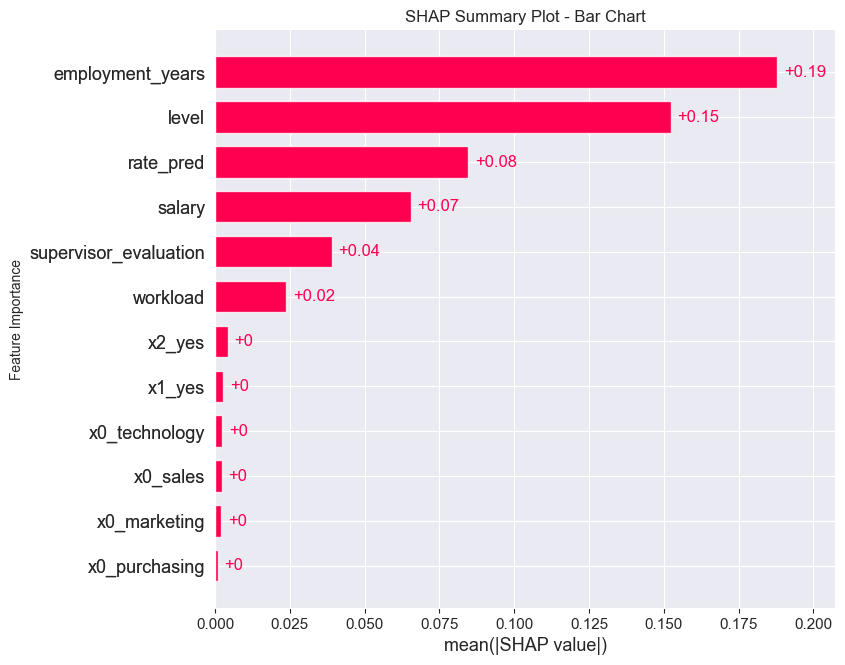

In [127]:
plt.title('SHAP Summary Plot - Bar Chart')
plt.ylabel('Feature Importance')
shap.plots.bar(shap_values, max_display=22)
plt.show()

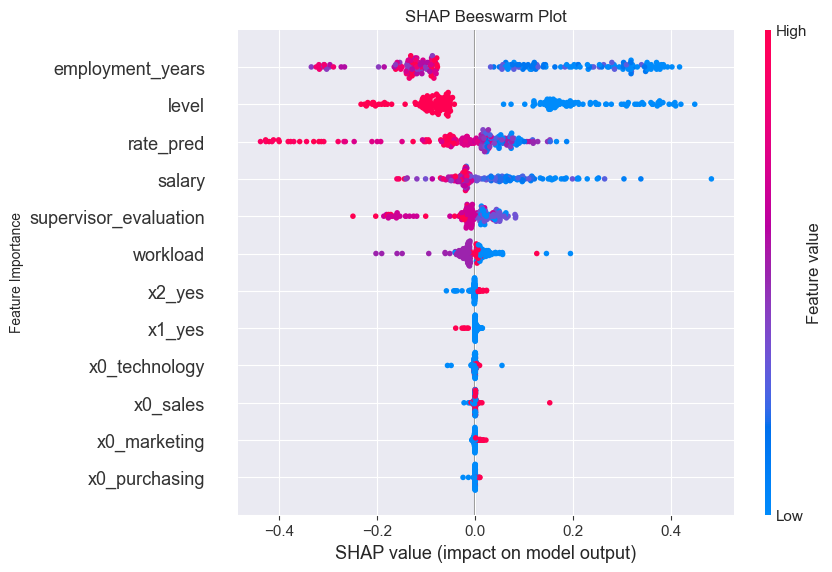

In [128]:
plt.title('SHAP Beeswarm Plot')
plt.ylabel('Feature Importance')
shap.plots.beeswarm(shap_values, max_display=22)
plt.show()

### Conclusion. Task 2.
The best result was achieved by grouping attributes as follows:

* OneHot Encoding — `'dept'`, `'last_year_promo'`, `'last_year_violations'`;
* Ordinal Encoding — `'level'`, `'workload'`;
* Numerical — `'employment_years'`, `'supervisor_evaluation'`, `'salary'`, `'rate_pred'`;

**Best model:**
`RandomForestClassifier(random_state=42)`, with parameters:

* `'models__max_depth'`: 6
* `'models__max_features'`: 3
* `'models__n_estimators'`: 100
* `'preprocessor__num'`: `StandardScaler()`

**roc\_auc** metric on training set = 0.91
**roc\_auc** metric on test set = 0.92

The most important features for the model were years of employment and job level. Additionally, job satisfaction, salary, supervisor evaluation, and workload also contributed to the model’s decisions.


## Conclusion

Models were developed to predict employee job satisfaction at the company *"Careful Work"* as well as whether an employee will leave the company.

1. **First task – regression:**
   Using a `RandomForestRegressor`, an SMAPE value of **13.75** was achieved.

2. **Second task – classification:**
   Due to class imbalance in the training data, techniques were applied to balance the number of samples in the majority and minority classes.
   The best result was achieved with a `RandomForestClassifier`, with a **roc\_auc** metric of **0.91**.

**Feature importance analysis** revealed that for both tasks, the key predictors were:

* Number of years at the company
* Job level
* Supervisor evaluation

**Recommendations:**
The company should pay close attention to new employees — they tend to have lower job satisfaction and are more likely to resign.
Since supervisor evaluation also had high importance, it’s worth examining how new specialists are assessed — ensuring they’re not being held to overly high standards or penalized for performance mismatches due to unrealistic expectations.
